In [1]:
%tensorflow_version 2.x

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
import sys
projectDir = "/content/drive/My Drive/code/git/tweepfake_deepfake_text_detection"
sys.path.insert(0, projectDir)
resultsDir = projectDir+"/data/results"
random_state = 523 # Fixed seed for replicability of randomic operations.

In [3]:
!pip install pandas transformers torch

     |████████████████████████████████| 778kB 4.7MB/s 
     |████████████████████████████████| 890kB 22.3MB/s 
     |████████████████████████████████| 3.0MB 33.5MB/s 
     |████████████████████████████████| 1.1MB 56.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=b11c5cdbfc0fcc10ff9d52c0ce72f88c9c2e20dc0a5440e6d0788ea1aec9d927
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [5]:
from DataHandler import DataHandler

csvTrainDataset = projectDir+"/data/splits/train.csv"
csvValDataset = projectDir+"/data/splits/validation.csv"
csvTestDataset = projectDir+"/data/splits/test.csv"

bertDir = projectDir+"/data/encoded/bert"
dh = DataHandler()
dfTrain = dh.readCSVData(csvTrainDataset)
dfVal = dh.readCSVData(csvValDataset)
dfTest = dh.readCSVData(csvTestDataset)

In [6]:
dfTrain

,N_prog,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favorite_count,retweet_count,quote_count,reply_count,hashtags,symbols,urls_url,urls_t.co,urls_expanded_url,media_url,media_t.co,media_expanded_url,media_type,ext_media_url,ext_media_t.co,ext_media_expanded_url,ext_media_type,mentions_user_id,mentions_screen_name,lang,quoted_status_id,quoted_text,quoted_created_at,quoted_source,quoted_favorite_count,quoted_retweet_count,quoted_user_id,...,place_url,place_name,place_full_name,place_type,country,country_code,geo_coords,coords_coords,bbox_coords,status_url,name,location,description,url,protected,followers_count,friends_count,listed_count,statuses_count,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,created,data.tweet,ora.tweet,tweet_type,mention_TF,hashtag_TF,url_TF,n.words,punct,account.type,finetuning_source,class_type
0,14692,x1110407881030017024,x1208265880146046976,2019-12-21 06:00:08,imranyebot,YEA now that note GOOD,imranye-twitter-bot,22,NaN,NaN,NaN,False,False,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA,NA NA NA NA NA NA NA NA,https://twitter.com/imranyebot/status/12082658...,imranyebot,NaN,@imranye in robot form. tweets every hour gene...,NaN,False,29,3,0,7467,0,2019-03-26 05:07:23,False,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/1110408254...,2019-12-21 06:00:08,2019-12-21,06:00:08,tweet,False,False,False,5,0,bot,imranye,others
1,22336,x3171109449,x1091463908118941696,2019-02-01 22:30:48,zawvrk,Listen to This Charming Man by The Smiths htt...,Twitter for iPhone,66,NaN,NaN,NaN,False,False,4,0,NaN,NaN,NaN,NaN,soundcloud.com/thesmiths/this…,https://t.co/r12OIXkfUO,https://soundcloud.com/thesmiths/this-charming...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA,NA NA NA NA NA NA NA NA,https://twitter.com/zawvrk/status/109146390811...,zawar,NaN,gold experience,https://t.co/J60plTSsKt,False,558,274,8,12216,23633,2015-04-15 19:50:16,False,https://t.co/J60plTSsKt,https://www.instagram.com/zawvr,NaN,https://pbs.twimg.com/profile_banners/31711094...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1229957200...,2019-02-01 22:30:48,2019-02-01,22:30:48,tweet,False,False,True,13,3,human,original,human
2,24087,x1110686081341632512,x1199055191028293633,2019-11-25 20:00:09,zawarbot,wish i can i would be seeing other hoes on the...,zawar-twitter-bot,57,NaN,NaN,NaN,False,False,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA,NA NA NA NA NA NA NA NA,https://twitter.com/zawarbot/status/1199055191...,zawarbot,NaN,I’m an AI Bot that tries to tweet like @zawvrk...,NaN,False,13,7,0,4054,9,2019-03-26 23:32:52,False,NaN,NaN,NaN,NaN,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1185589257...,2019-11-25 20:00:09,2019-11-25,20:00:09,tweet,False,False,False,13,0,bot,zawvrk,others
3,7584,x1110307772783124480,x1214698264701722626,2020-01-08 00:00:08,ahadsheriffbot,The decade in the significantly easier schedul...,ahadsheriff-bot,63,NaN,NaN,NaN,False,False,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NA NA,NA NA,NA NA NA NA NA NA NA NA,https://twitter.com/ahadsheriffbot/status/1214...,Robot Ahad Sheriff,NaN,@ahadsheriff in robot form. tweets every hour ...,https://t.co/2G243YsNOt,False,18,1,0,7946,0,2019-03-25 22:29:36,False,https://t.co/2G243YsNOt,https://ahadsheriff.com,NaN,NaN,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1110311752...,2020-01-08 00:00:08,2020-01-08,00:00:08,tweet,Fa

In [7]:
# creating bool series True for NaN values 
bool_series = dfTrain.isnull() 
  
# filtering data 
# displayind data only with team = NaN 
dfTrain[bool_series]

,N_prog,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favorite_count,retweet_count,quote_count,reply_count,hashtags,symbols,urls_url,urls_t.co,urls_expanded_url,media_url,media_t.co,media_expanded_url,media_type,ext_media_url,ext_media_t.co,ext_media_expanded_url,ext_media_type,mentions_user_id,mentions_screen_name,lang,quoted_status_id,quoted_text,quoted_created_at,quoted_source,quoted_favorite_count,quoted_retweet_count,quoted_user_id,...,place_url,place_name,place_full_name,place_type,country,country_code,geo_coords,coords_coords,bbox_coords,status_url,name,location,description,url,protected,followers_count,friends_count,listed_count,statuses_count,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,created,data.tweet,ora.tweet,tweet_type,mention_TF,hashtag_TF,url_TF,n.words,punct,account.type,finetuning_source,class_type
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20710,NaN,NaN

In [8]:
# Select interesting columns for this study.
dfTrainDataset = dfTrain[["screen_name", "text", "account.type"]]
dfValDataset = dfVal[["screen_name", "text", "account.type"]]
dfTestDataset = dfTest[["screen_name", "text", "account.type"]]

In [9]:
dfTrainDataset

,screen_name,text,account.type
0,imranyebot,YEA now that note GOOD,bot
1,zawvrk,Listen to This Charming Man by The Smiths htt...,human
2,zawarbot,wish i can i would be seeing other hoes on the...,bot
3,ahadsheriffbot,The decade in the significantly easier schedul...,bot
4,kevinhookebot,"""Theim class=\""alignnone size-full wp-image-60...",bot
...,...,...,...
20707,AINarendraModi,Met on the Abversion of our science for the co...,bot
20708,AINarendraModi,Land for their during the opportunity to the p...,bot
20709,DeepDrumpf,@TayandYou doesn't have a clue. You're right. ...,bot
20710,jaden,Me And My Bestie https://t.co/vPq2iDkWZm,human


In [10]:
import os
from numpy import savetxt
from numpy import loadtxt

def tokenizeTweets(df):
  
  import torch
  from transformers import BertTokenizer, BertModel, pipeline
  import numpy as np

  pretrained_weights = "bert-base-cased"
  tokenizer = BertTokenizer.from_pretrained(pretrained_weights)
  model = BertModel.from_pretrained(pretrained_weights)

  nlp = pipeline("feature-extraction", tokenizer=tokenizer, model=model)

  vectorized_docs = []
  count = 0
  for index, row in df.iterrows():
    # Encode text
    vec = np.array(nlp(row["text"][:512]))
    meanVec = vec.reshape((vec.shape[1], vec.shape[2])).mean(axis=0)
    vectorized_docs.append(meanVec)
    count = count + 1
    if count % 100 == 0:
      print("->"+str(count)) 

  return np.array(vectorized_docs)


fname = bertDir+"/train.vec"
os.makedirs(bertDir, exist_ok=True)
if not os.path.exists(fname):
  train_features = tokenizeTweets(dfTrainDataset)
  savetxt(fname, train_features, delimiter=';')
else:
  train_features = loadtxt(fname, delimiter=';')

fname = bertDir+"/val.vec"
if not os.path.exists(fname):
  val_features = tokenizeTweets(dfValDataset)
  savetxt(fname, val_features, delimiter=';')
else:
  val_features = loadtxt(fname, delimiter=';')

fname = bertDir+"/test.vec"
if not os.path.exists(fname):
  test_features = tokenizeTweets(dfTestDataset)
  savetxt(fname, test_features, delimiter=';')
else:
  test_features = loadtxt(fname, delimiter=';')


->100
->200
->300
->400
->500
->600
->700
->800
->900
->1000
->1100
->1200
->1300
->1400
->1500
->1600
->1700
->1800
->1900
->2000
->2100
->2200
->2300
->2400
->2500
->2600
->2700
->2800
->2900
->3000
->3100
->3200
->3300
->3400
->3500
->3600
->3700
->3800
->3900
->4000
->4100
->4200
->4300
->4400
->4500
->4600
->4700
->4800
->4900
->5000
->5100
->5200
->5300
->5400
->5500
->5600
->5700
->5800
->5900
->6000
->6100
->6200
->6300
->6400
->6500
->6600
->6700
->6800
->6900
->7000
->7100
->7200
->7300
->7400
->7500
->7600
->7700
->7800
->7900
->8000
->8100
->8200
->8300
->8400
->8500
->8600
->8700
->8800
->8900
->9000
->9100
->9200
->9300
->9400
->9500
->9600
->9700
->9800
->9900
->10000
->10100
->10200
->10300
->10400
->10500
->10600
->10700
->10800
->10900
->11000
->11100
->11200
->11300
->11400
->11500
->11600
->11700
->11800
->11900
->12000
->12100
->12200
->12300
->12400
->12500
->12600
->12700
->12800
->12900
->13000
->13100
->13200
->13300
->13400
->13500
->13600
->13700
->13800
->1

In [11]:
from sklearn.model_selection import train_test_split


X_train_all = dfTrainDataset
X_val_all = dfValDataset
X_test_all = dfTestDataset
dictLabels = {"human":0, "bot":1}
dictLabelsReverse = {0:"human", 1: "bot"}
y_train = dfTrainDataset["account.type"].apply(lambda x: dictLabels[x])
y_val = dfValDataset["account.type"].apply(lambda x: dictLabels[x])
y_test = dfTestDataset["account.type"].apply(lambda x: dictLabels[x])


In [12]:
train_labels = y_train.tolist()
val_labels = y_val.tolist()
test_labels = y_test.tolist()

In [13]:
from sklearn.svm import SVC

# Test SVC.
tuned_parameters = [#{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     # 'C': [1, 10, 100, 1000]},
                      #{'kernel': ['linear'], 'C': [0.1, 1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1.0]}]
model = SVC()
y_pred_svc, best_params_svc = dh.testSKLearnModel(model, tuned_parameters, train_features, val_features, test_features, train_labels, val_labels, test_labels)

Model tested: <class 'sklearn.svm._classes.SVC'>
Best parameters set found on development set:

{'C': 1.0, 'kernel': 'linear'}

Grid scores on development set:

0.842 (+/-0.000) for {'C': 1.0, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0      0.860     0.818     0.838      1278
           1      0.827     0.867     0.846      1280

    accuracy                          0.842      2558
   macro avg      0.843     0.842     0.842      2558
weighted avg      0.843     0.842     0.842      2558




In [14]:
import pandas as pd

predictionLabels = [dictLabelsReverse[t] for t in y_pred_svc]
dfResults = pd.DataFrame(predictionLabels, columns=["prediction"])
dfResults["gold"] = dfTestDataset[["account.type"]]
file_name = resultsDir+"/svc_bert.csv"
dfResults.to_csv(file_name, sep='\t', encoding='utf-8')

In [15]:
from sklearn.linear_model import LogisticRegression

# Test logistic regression.
model = LogisticRegression(solver='liblinear')
tuned_parameters = {'C': [1]}
y_pred_log_reg, best_params_log_reg = dh.testSKLearnModel(model, tuned_parameters, train_features, val_features, test_features, train_labels, val_labels, test_labels)

Model tested: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Best parameters set found on development set:

{'C': 1}

Grid scores on development set:

0.835 (+/-0.000) for {'C': 1}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0      0.846     0.820     0.833      1278
           1      0.826     0.851     0.838      1280

    accuracy                          0.835      2558
   macro avg      0.836     0.835     0.835      2558
weighted avg      0.836     0.835     0.835      2558




In [16]:
import pandas as pd

predictionLabels = [dictLabelsReverse[t] for t in y_pred_log_reg]
dfResults = pd.DataFrame(predictionLabels, columns=["prediction"])
dfResults["gold"] = dfTestDataset[["account.type"]]
file_name = resultsDir+"/logistic_regression_bert.csv"
dfResults.to_csv(file_name, sep='\t', encoding='utf-8')

In [17]:
#X_test_all["label_log_reg"] = [dictLabelsReverse[t] for t in y_pred_log_reg]

In [18]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = [100]
max_depth = [30]
min_samples_split = [15]
min_samples_leaf = [2] 

tuned_parameters = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
            min_samples_leaf = min_samples_leaf)
model = RandomForestClassifier(random_state = random_state)


y_pred_rand_forest, best_params_rand_forest = dh.testSKLearnModel(model, tuned_parameters, train_features, val_features, test_features, train_labels, val_labels, test_labels)

Model tested: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Best parameters set found on development set:

{'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 100}

Grid scores on development set:

0.820 (+/-0.000) for {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 100}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0      0.864     0.776     0.818      1278
           1      0.797     0.878     0.836      1280

    accuracy                          0.827      2558
   macro avg      0.831     0.827     0.827      2558
weighted avg      0.831     0.827     0.827      2558




In [19]:
import pandas as pd

predictionLabels = [dictLabelsReverse[t] for t in y_pred_rand_forest]
dfResults = pd.DataFrame(predictionLabels, columns=["prediction"])
dfResults["gold"] = dfTestDataset[["account.type"]]
file_name = resultsDir+"/random_forest_bert.csv"
dfResults.to_csv(file_name, sep='\t', encoding='utf-8')

In [20]:
X_test_all["label_rand_forest"] = [dictLabelsReverse[t] for t in y_pred_rand_forest]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
def plotErrorRatio(X_test_all, prediction_column, min_sample_num=30):
  X_verify = X_test_all[["screen_name", "text", "account.type", prediction_column]]
  X_count_accounts = X_test_all[["screen_name", "account.type"]].groupby("screen_name").count()
  X_verify = X_verify[X_verify["account.type"] != X_verify[prediction_column]]
  X_verify = X_verify.groupby("screen_name").count()["text"].to_frame()
  X_verify["total"] = X_count_accounts["account.type"]
  X_verify.columns = ["errors", "num_samples"]
  X_verify["error_ratio"] = X_verify["errors"] / X_verify["num_samples"]
  X_verify[X_verify["num_samples"] >= min_sample_num]["error_ratio"].plot.bar(figsize=(15,5))
  return X_verify

In [22]:
#plotErrorRatio(X_test_all, "label_log_reg")

,errors,num_samples,error_ratio
screen_name,,,
AINarendraModi,7,125,0.056000
DeepDrumpf,6,29,0.206897
GenePark_GPT2,4,22,0.181818
Gpt2Wint,2,2,1.000000
Musk_from_Mars,1,2,0.500000
Thorin,2,10,0.200000
UtilityLimb,1,4,0.250000
VBoterin,4,13,0.307692
VitalikButerin,1,13,0.076923


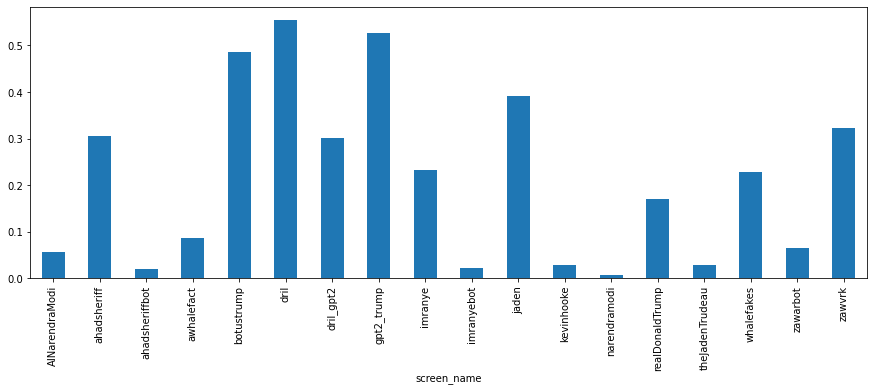

In [23]:
plotErrorRatio(X_test_all, "label_rand_forest")